In [1]:
from PyQt5.QtCore import *
from PyQt5.QtGui import *
from PyQt5.QtWidgets import *

import matplotlib.pyplot as plt
import numpy as np
import scipy as sc
import random
from matplotlib.backends.backend_qt5agg import (NavigationToolbar2QT as NavigationToolbar)
from matplotlib.backends.backend_qt5agg import FigureCanvasQTAgg as FigureCanvas


import sys
import time
import os

In [3]:
%run "DAL/file_manager.ipynb"

In [4]:
%run "BLL/widget_graphics.ipynb"
%run "BLL/network_logic.ipynb"

In [2]:
%run "UI/main_window.ipynb"
%run "UI/dialog_topology_config.ipynb"

## Multithreading

In [5]:
class Worker(QRunnable):
    '''
    Worker thread

    Inherits from QRunnable to handler worker thread setup, signals and wrap-up.

    :param callback: The function callback to run on this worker thread. Supplied args and
                     kwargs will be passed through to the runner.
    :type callback: function
    :param args: Arguments to pass to the callback function
    :param kwargs: Keywords to pass to the callback function

    '''

    def __init__(self, parent, fn, *args, **kwargs):
        super(Worker, self).__init__()
        # Store constructor arguments (re-used for processing)
        self.parent = parent
        self.parent.fn = fn
        self.args = args
        self.kwargs = kwargs

    @pyqtSlot()
    def run(self):
        '''
        Initialise the runner function with passed args, kwargs.
        '''
        self.parent.fn(*self.args, **self.kwargs)

## Window: *Topology Editor*

In [6]:
class TopologyEditor(QDialog, Ui_Dialog):
    def __init__(self, parent):
        super().__init__(parent)
        self.setup_ui(self)
        self.parent = parent
        self.setup_data()
        self.setup_buttons()
        self.setup_topology()
        self.setup_draw()
        self.show_hidden_layers()
        self.tableWidget_hidden_layers.horizontalHeader().setStretchLastSection(True)

        
    def setup_data(self):
        
        activation_functions_hidden = ActivationFunction().names_activation_functions_hidden
        activation_functions_final = ActivationFunction().names_activation_functions_final
                
        self.comboBox_activation_function_hidden.addItems(activation_functions_hidden)
        self.comboBox_activation_function_final.addItems(activation_functions_final)
        
        self.tableWidget_hidden_layers.setRowCount(1)
        self.tableWidget_hidden_layers.setColumnCount(2)
        self.tableWidget_hidden_layers.setItem(0, 0, QTableWidgetItem("Número de neuronas"))
        self.tableWidget_hidden_layers.setItem(0, 1, QTableWidgetItem("Funcion de activación"))
             
        
    
    def setup_buttons(self):
        
        self.pushButton_add_hidden_layer.clicked.connect(self.add_hidden_layer)
        
        self.pushButton_save_topology.clicked.connect(self.save_topology)
        self.pushButton_reset_topology.clicked.connect(self.reset_topology)
        
    
    def setup_topology(self):
        
        try:
            self.topology = self.parent.topology.copy()
            self.activation_functions = self.parent.activation_functions.copy()
            
            del self.activation_functions[-1]
            
            self.comboBox_activation_function_final.setCurrentIndex(self.parent.activation_functions[-1])
        
        except:
            
            self.topology = [self.parent.dataset.n_X, self.parent.dataset.n_Y]
        
            self.activation_functions = [-1]            
        
    
    def add_hidden_layer(self):
        
        self.topology.insert(-1, int(self.lineEdit_neurons_number_hidden.text()))
        
        self.activation_functions.append(self.comboBox_activation_function_hidden.currentIndex())
        
        self.clean_inputs()
        
        self.show_hidden_layers()
        
        
    def show_hidden_layers(self):
        
        _nx = len(self.topology)
        
        self.tableWidget_hidden_layers.setRowCount(_nx-1)
        
        for i_x in range(1, _nx-1):
            
            self.tableWidget_hidden_layers.setItem(i_x, 0, QTableWidgetItem(str(self.topology[i_x])))
            
        for i_x in range(1, _nx-1):
            
            self.tableWidget_hidden_layers.setItem(i_x, 1, QTableWidgetItem(ActivationFunction().names_activation_functions_hidden[self.activation_functions[i_x]]))
            
        self.draw_nn()

    
    def save_topology(self):
        
        self.activation_functions.append(self.comboBox_activation_function_final.currentIndex())
        
        self.parent.topology = self.topology
        self.parent.activation_functions = self.activation_functions
        
        self.close()
        
    def reset_topology(self):
        
        self.topology = [self.parent.dataset.n_X, self.parent.dataset.n_Y]
        
        self.activation_functions = [-1]
        
        self.show_hidden_layers()
        
        self.clean_inputs()
        
        self.comboBox_activation_function_final.setCurrentIndex(0)
        
        
    def clean_inputs(self):
        self.lineEdit_neurons_number_hidden.setText("")
        self.comboBox_activation_function_hidden.setCurrentIndex(0)
        
        
        
        
        
    def draw_nn(self):
        
        widest_layer = max(self.topology)
        self.graphic_neural_network = GraphicNeuralNetwork(widest_layer)
        for l in self.topology:
            self.graphic_neural_network.add_layer(l)
        self.draw()
        
        
        
        
    def draw(self):
        for i in range( len(self.graphic_neural_network.layers) ):
            layer = self.graphic_neural_network.layers[i]
            if i == len(self.graphic_neural_network.layers)-1:
                i = -1
            layer.draw( i )
        plt.axis('scaled')
        plt.axis('off')
        
        self.widget_topology_diagram.canvas.draw_idle()
        
        
        
    def setup_draw(self):
        widest_layer = max(self.topology)
        self.graphic_neural_network = GraphicNeuralNetwork(widest_layer)
        for l in self.topology:
            self.graphic_neural_network.add_layer(l)
        self.figur = plt.figure()
        for i in range( len(self.graphic_neural_network.layers) ):
            layer = self.graphic_neural_network.layers[i]
            if i == len(self.graphic_neural_network.layers)-1:
                i = -1
            layer.draw( i )
        plt.axis('scaled')
        plt.axis('off')
        
        self.widget_topology_diagram.canvas = FigureCanvas(self.figur)
        _vertical_layout = QVBoxLayout()
        _vertical_layout.addWidget(self.widget_topology_diagram.canvas)
        self.widget_topology_diagram.setLayout(_vertical_layout)
        
        self.widget_topology_diagram.canvas.draw_idle()
        

## Window: *Main*

In [7]:
class MainWindow(QMainWindow, Ui_MainWindow):
    def __init__(self):
        super().__init__()
        self.setup_ui(self, "UI")
        self.setup_actions()
        
        
    def setup_actions(self):
        
        self.action_new.triggered.connect(self.new_project)
        
    def setup_buttons(self):
        self.pushButton_upload_dataset.clicked.connect(self.upload_dataset)
        self.pushButton_delete_dataset.clicked.connect(self.delete_dataset)

        self.pushButton_open_topology_editor.clicked.connect(self.open_topology_editor)
        
        self.pushButton_execute.clicked.connect(lambda:self.multithreading(self.prepare_execute))
        
        
        
    def new_project(self):
        
        try:
            project_path, _format = QFileDialog.getSaveFileName(self, 'New project', '/home/earodriguezm/', "NeuNet (.neunet)")
        except:
            QMessageBox.about(self, "Error", "Error en la creación del proyecto")
            return False
        
        self.file_manager = FileManager(project_path)
        
        self.setWindowTitle(self.file_manager.project_name)
        
        self.create_q_objects(self)
        self.setup_buttons()
        self.tableWidget_dataset.horizontalHeader().setStretchLastSection(True)

        
        
    def upload_dataset(self):

        try:
            dataset_path, _format = QFileDialog.getOpenFileName(self, 'Upload dataset file', self.file_manager.project_path, "CSV (*.csv) ;; TSV (*.tsv)")
        except:
            QMessageBox.about(self, "Error", "Error en la creación del proyecto")
            return False
        
        if _format == "CSV (*.csv)":
            delimiter_format = ','           
        if _format == "TSV (*.tsv)":
            delimiter_format = '\t'
        
        self.lineEdit_dataset_filename.setText(dataset_path)
        
        self.file_manager.dataset_path = dataset_path
        self.file_manager.delimiter_format = delimiter_format
        self.show_dataset()
        
        self.dataset = Dataset(self.file_manager.count_in_out())
        self.draw_nn([self.dataset.n_X, self.dataset.n_Y])
        
        self.dataset.import_X_dataset(self.file_manager)
        self.dataset.import_Y_dataset(self.file_manager)
        self.set_default_config()
        
    def delete_dataset(self):
        
        self.lineEdit_dataset_filename.setText(None)
        self.file_manager.dataset_path = None
        self.file_manager.delimiter_format = None
        
        self.tableWidget_dataset.clear()
        
        self.set_backpropagation_options(False)
        self.set_execute_button_status(False)
        
        self.dataset = None
        
    def show_dataset(self):
        
        _data = self.file_manager.import_file(self.file_manager.dataset_path)
        
        _x, _y = _data.shape
        self.tableWidget_dataset.setRowCount(_x)
        self.tableWidget_dataset.setColumnCount(_y)
        
        for i_x in range(0, _x):
            for i_y in range(0, _y):
                self.tableWidget_dataset.setItem(i_x, i_y, QTableWidgetItem(_data[i_x, i_y]))
                
                
                
                
                
                

                
    def draw_nn(self, topology):
        
        widest_layer = max(topology)
        self.graphic_neural_network = GraphicNeuralNetwork(widest_layer)
        for l in topology:
            self.graphic_neural_network.add_layer(l)
        self.draw()
        
        
        
        
    def draw(self):
    
        figur = plt.figure()
        for i in range( len(self.graphic_neural_network.layers) ):
            layer = self.graphic_neural_network.layers[i]
            if i == len(self.graphic_neural_network.layers)-1:
                i = -1
            layer.draw( i )
        plt.axis('scaled')
        plt.axis('off')
        
        self.widget_topology_diagram.canvas = FigureCanvas(figur)
        _vertical_layout = QVBoxLayout()
        _vertical_layout.addWidget(self.widget_topology_diagram.canvas)
        self.widget_topology_diagram.setLayout(_vertical_layout)
        
        self.widget_topology_diagram.canvas.draw()
        
        

        
        
        
        
        
        
        
        
        
        
    def set_default_config(self):

        self.lineEdit_learning_ratio.setText("0.01")
        self.lineEdit_iterations.setText("1000")
        self.lineEdit_err_max.setText("0.1")
        self.lineEdit_res.setText("50")
        self.lineEdit_interval_show.setText("2")
        
        self.set_backpropagation_options(True)
        
    def open_topology_editor(self):

        topology_editor = TopologyEditor(self)
        topology_editor.exec()
        try:
            self.draw_nn(self.topology)
        except:
            print("a")
        
        
    def set_backpropagation_options(self, status = False):
        
        self.radioButton_backpropagation_primitive.setEnabled(status)
        self.radioButton_backpropagation_primitive.toggled.connect(lambda:self.set_execute_button_status(True))
        
        self.radioButton_backpropagation_cascade.setEnabled(status)
        self.radioButton_backpropagation_cascade.toggled.connect(lambda:self.set_execute_button_status(True))
        
        self.radioButton_backpropagation_without.setEnabled(status)
        self.radioButton_backpropagation_without.toggled.connect(lambda:self.set_execute_button_status(True)) 
        
        self.pushButton_open_topology_editor.setEnabled(status)
        
    def set_execute_button_status(self, status = True):
        
        try:
            if len(self.activation_functions) >= 2:
                self.pushButton_execute.setEnabled(True)
        except:
            
            QMessageBox.about(self, "Error", "No se ha seleccionado la funcion de activacion en la ultima capa de la red")
    
    
    def multithreading(self, fn, *args, **kwargs):
        self.threadpool = QThreadPool()
        print("Multithreading with maximum %d threads" % self.threadpool.maxThreadCount())
        worker = Worker(self, fn, *args, **kwargs)
        self.threadpool.start(worker)
        print("this run")
        
    
    
    def prepare_execute(self):
        
        if not self.values_Validator:
            return False
        
        self.create_red_config()
        
        backpropagation_type = None
        
        if self.radioButton_backpropagation_primitive.isChecked():
            backpropagation_type = 0
        
        if self.radioButton_backpropagation_cascade.isChecked():
            backpropagation_type = 1

        backpropagation = not self.radioButton_backpropagation_without.isChecked()
        
        # FIX THE RELATION BETWEEN ACTIVATION FUNCTIONS INDEX AND THE FUNCTION

        array_functions = [-1]

        for i in range(1,len(self.activation_functions)):
        
            array_functions.append(ActivationFunction().get_array_functions()[i])
        
        # Create NeuralNetwork instance
        
        #Add function validator for the last layer
        time.sleep(0.1)
        self.tabWidget.setCurrentIndex(1)
        QApplication.processEvents()
        
        try:
            if self.neural_network == None:
                self.neural_network = NeuralNetwork(self.topology, array_functions, self.red_config, self.dataset)
            else:
                self.neural_network.topology = self.topology
                self.neural_network.activation_functions = array_functions
                self.neural_network.red_config = self.red_config
                self.neural_network.dataset = self.dataset
                
        except:
            
            self.neural_network = NeuralNetwork(self.topology, array_functions, self.red_config, self.dataset)
        
        self.multithreading(self.execute,backpropagation, backpropagation_type)
        
    def values_Validator(self):
        
        if float(self.lineEdit_learning_ratio.text()) == 0:
            QMessageBox.about(self, "Error", "Error en el ratio de aprendizaje ingresado")
            return False
        if int(self.lineEdit_iterations.text()) == 0:
            QMessageBox.about(self, "Error", "Error en el numero de iteraciones ingresado")
        if float(self.lineEdit_err_max.text()) == 0:
            QMessageBox.about(self, "Error", "Error en el error maximo permitido ingresado")
            return False
        if int(self.lineEdit_res.text()) == 0:
            QMessageBox.about(self, "Error", "Error en el valor de resolución ingresado")
            return False
        if int(self.lineEdit_interval_show.text()) == 0:
            QMessageBox.about(self, "Error", "Error en el valor de intervalo a mostrar")
            return False
        return True
    
    def create_red_config(self):
        
        self.red_config = RedConfig(float(self.lineEdit_learning_ratio.text()), int(self.lineEdit_iterations.text()), float(self.lineEdit_err_max.text()), int(self.lineEdit_res.text()), int(self.lineEdit_interval_show.text()))

    
    def execute(self, backpropagation, backpropagation_type):
        
        err_iterations = []
        x_axis = []
        
        #Here need to call interval_generator()
        
        for i in range(self.red_config.get_iteration_limit()):
            
            Y_iteration = self.neural_network.train(backpropagation, backpropagation_type)
            
            if i % self.red_config.get_interval_show() == 0 :
                
                err_iterations.append(self.neural_network.cost_function[0](Y_iteration, self.dataset.Y))
                
                #Need to call plot_generator()
                x_axis.append(i)
                self.multithreading(self.plot_error_iteration, x_axis, err_iterations)
                time.sleep(1)
            
            if err_iterations[-1] <= self.red_config.get_err_max():
                
                if i % self.red_config.get_interval_show() != 0:
                    
                    err_iterations.append(self.neural_network.cost_function[0](Y_iteration, self.dataset.Y))
                
                    #Need to call plot_generator()
                    
                    x_axis.append(i)
                    self.multithreading(self.plot_error_iteration, x_axis, err_iterations)
                    time.sleep(1)
                return err_iterations
            
            
    def plot_error_iteration(self, x_axis, err_iterations):
        
        self.widget_err_iterations.canvas = FigureCanvas(Figure())
        _vertical_layout = QVBoxLayout()
        _vertical_layout.addWidget(self.widget_err_iterations.canvas)
        
        #Three integers (nrows, ncols, index)
        self.widget_err_iterations.canvas.axes = self.widget_err_iterations.canvas.figure.add_subplot(111)
        self.widget_err_iterations.setLayout(_vertical_layout)
        
        self.widget_err_iterations.canvas.axes.clear()
        self.widget_err_iterations.canvas.axes.plot(x_axis, err_iterations)
        self.widget_err_iterations.canvas.axes.legend('Error de iteracion', loc = 'upper right')
        self.widget_err_iterations.canvas.draw()
        

AttributeError: 'Figure' object has no attribute 'cla'

0

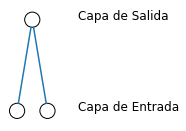

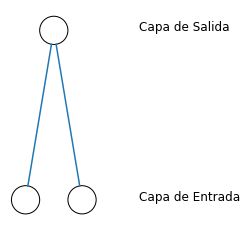

In [8]:
app = QApplication(sys.argv)
main_window = MainWindow()
main_window.show()
app.exec_()